In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import chardet
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adamax 
from keras import regularizers
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/NNDL/Assignment2 /IMDB_Dataset.csv')
df = pd.read_csv('https://drive.google.com/uc?id=13skTlmf1OiiM8sN6eoLPTToJu5zfdzui&export=download ') #IMDB_Dataset.csv public direct URL

def encode_sentiment_as_label(row): # Quick one hot encoding
    if row['sentiment'] == "positive":
        return 1
    else:
        return 0

df['label'] = df.apply(lambda row: encode_sentiment_as_label(row), axis=1)
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [5]:
labels = df['label']

def featureEngineering(rev):
    # Lower case rev
    revMod = rev.lower()
    # Remove <br />
    revMod = revMod.replace('<br />','')
    # Replace URLs with a space in the message
    revMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', revMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    revMod = re.sub('\$[a-zA-Z0-9]*', ' ', revMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    revMod = re.sub('\@[a-zA-Z0-9]*', ' ', revMod)
    # Replace everything not a letter or apostrophe with a space
    revMod = re.sub('[^a-zA-Z\']', ' ', revMod)
    # Remove single letter words
    revMod = ' '.join([w for w in revMod.split() if len(w) > 1])

    return revMod


# Process for all revs
df['modrev'] = [featureEngineering(rev) for rev in df['review']]

def lemmatizerev(rev):
    words = [word for word in word_tokenize(rev) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return " ".join(lemmatized)

df['lemmatizedText'] = df["modrev"].apply(lambda x:lemmatizerev(x))

In [6]:
tokenizer = Tokenizer(num_words=37320, split=' ')
tokenizer.fit_on_texts(df['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(df['lemmatizedText'].values)
X = pad_sequences(X)

X_train, X_test, valid_train, valid_test = train_test_split(X, labels, test_size=0.7, random_state=42)

# Split X_test and valid_test store as Y_test, Y_true. This will be used for separate evaluation of model
Y_true = valid_test[int(len(valid_test)/4)*3::] # Set Y_true = 2nd 25% of labels from test set (Ground truth for evaluation)
Y_test = X_test[int(len(X_test)/4)*3::]# Set Y_test = 2nd 25% of rows from test set

X_test = X_test[0:int(len(X_test)/4)*3] # Set X_test to the 1st 25% of X_test
valid_test = valid_test[0:int(len(valid_test)/4)*3] # Set valid_test to the 1st 25% of valid_test

In [31]:
print(X_train.shape,valid_train.shape)
print(X_test.shape,valid_test.shape)
print(Y_test.shape)
print(set(stopwords.words('english')))
print("\n")
print((df['review'][0]))
print(word_tokenize(df['review'][0]))
#print(df['modrev'][0])
print(df['lemmatizedText'][0])

(15000, 1373) (15000,)
(26250, 1373) (26250,)
(8750, 1373)
{'some', 'ours', "doesn't", 'down', 'and', 'our', 'below', 'nor', 'himself', 'myself', 'few', 'don', "mustn't", 'hers', 'both', 'you', 'will', "you'd", 'too', 'against', 'him', 'when', "hadn't", 'how', "shan't", 'above', 'than', 'this', 'during', 'mustn', 'is', 'as', 'ma', 'needn', 'his', 'to', 'theirs', 'me', 'off', 'about', 'here', 'we', 'the', 'there', 'ourselves', 'any', 'haven', 'all', "it's", 'a', "haven't", 'she', 'which', 'who', 'just', 'am', 'were', 'couldn', 'wouldn', 'itself', 'at', 'most', 'yours', 'doing', 'now', 'very', 're', "don't", 'into', 'has', 't', 'y', 'after', 'aren', 'i', 'if', 'they', 'whom', 'shouldn', 'before', 'yourself', 'where', 'its', 'under', 'up', 'ain', 'more', 'until', 'while', 'between', 'each', 'did', 'hadn', 'won', 'so', 'he', 'it', 'those', 's', 'same', "hasn't", 'no', "you're", 'from', "she's", 'have', 'them', 'in', 'an', 'weren', 'yourselves', 'wasn', 'had', 'or', 'only', "aren't", 'shoul

In [8]:
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim=37320, output_dim=40, input_length=X.shape[1]))
model_dropout.add(Dropout(0.5))
model_dropout.add(Bidirectional(LSTM(units=256, return_sequences=True, kernel_initializer='he_uniform')))
model_dropout.add(Dropout(0.5))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False, kernel_initializer='he_uniform')))
model_dropout.add(Dense(1, activation='sigmoid'))
optimizer = Adamax(learning_rate = 0.01)
model_dropout.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model_dropout.summary())
from keras.utils import plot_model
plot_model(model_dropout, show_shapes = True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1373, 40)          1492800   
                                                                 
 dropout_2 (Dropout)         (None, 1373, 40)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1373, 512)        608256    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1373, 512)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                

In [54]:
history = model_dropout.fit(X_train, valid_train, epochs = 50, batch_size=256, validation_data=(X_test, valid_test))

Epoch 1/50
59/59 [==============================] - 29s 497ms/step - loss: 0.0765 - accuracy: 0.9727 - val_loss: 0.6072 - val_accuracy: 0.8280
Epoch 2/50
59/59 [==============================] - 29s 497ms/step - loss: 0.0752 - accuracy: 0.9734 - val_loss: 1.4278 - val_accuracy: 0.6982
Epoch 3/50
59/59 [==============================] - 29s 499ms/step - loss: 0.3952 - accuracy: 0.8369 - val_loss: 0.6390 - val_accuracy: 0.7402
Epoch 4/50
59/59 [==============================] - 29s 499ms/step - loss: 0.2257 - accuracy: 0.9110 - val_loss: 0.6326 - val_accuracy: 0.7663
Epoch 5/50
59/59 [==============================] - 29s 501ms/step - loss: 0.1621 - accuracy: 0.9388 - val_loss: 0.5888 - val_accuracy: 0.8017
Epoch 6/50
59/59 [==============================] - 29s 500ms/step - loss: 0.1330 - accuracy: 0.9499 - val_loss: 0.5523 - val_accuracy: 0.8160
Epoch 7/50
59/59 [==============================] - 29s 500ms/step - loss: 0.1108 - accuracy: 0.9585 - val_loss: 0.5709 - val_accuracy: 0.8184

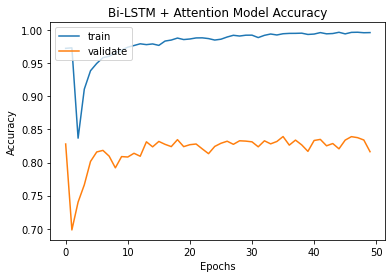

In [63]:
# Plotting the accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bi-LSTM + Attention Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
#plt.savefig('./overall_acc.png')

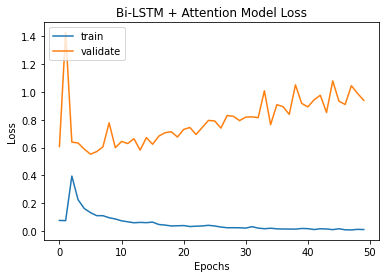

In [68]:
# Plotting the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM + Attention Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='upper left')
#plt.savefig('./overall_loss.png')

274/274 [==============================] - 22s 81ms/step
              precision    recall  f1-score   support

           0     0.8123    0.8244    0.8183      4409
           1     0.8189    0.8065    0.8127      4341

    accuracy                         0.8155      8750
   macro avg     0.8156    0.8155    0.8155      8750
weighted avg     0.8156    0.8155    0.8155      8750

Micro F1 Score: 0.8155428571428572
Macro F1 Score: 0.8154995867504287
Accuracy Score: 0.8155428571428571


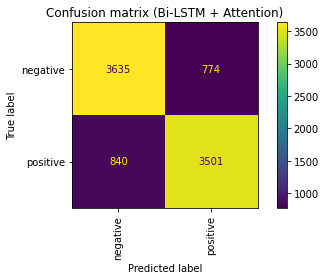

In [66]:
Y_pred = model_dropout.predict(Y_test)
Y_pred = Y_pred.flatten()

def prediction_value_to_label(row):
    if row['y_pred_val'] > 0.5:
        return 1
    else:
        return 0

out = pd.DataFrame()
out['y_pred_val'] = Y_pred
out['y_pred'] = out.apply(lambda row: prediction_value_to_label(row), axis=1)

print(classification_report(Y_true, out["y_pred"], digits=4))
print(f'Micro F1 Score: {f1_score(Y_true, out["y_pred"], average="micro")}')
print(f'Macro F1 Score: {f1_score(Y_true, out["y_pred"], average="macro")}')
print(f'Accuracy Score: {accuracy_score(Y_true, out["y_pred"])}')

cm = confusion_matrix(Y_true, out['y_pred'], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        display_labels=['negative','positive'])
disp.plot()
plt.title('Confusion matrix (Bi-LSTM + Attention)')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig("figure")

In [67]:
model_dropout.save('./bi_lstm')
model_dropout.save('./bi_lstm.h5')

INFO:tensorflow:Assets written to: ./bi_lstm/assets


INFO:tensorflow:Assets written to: ./bi_lstm/assets
